# Showing Sample Game & Series Simulation

In [1]:
%matplotlib inline
%run random_game.py

Running sample game between a Home Team and an Away Teams...

Out for Away Team! Home 0, Away 0 with 1 outs in the Top of the 1st, with no runners on
Out for Away Team! Home 0, Away 0 with 2 outs in the Top of the 1st, with no runners on
Out for Home Team! Home 0, Away 0 with 0 outs in the Bottom of the 1st, with no runners on
Out for Home Team! Home 0, Away 0 with 1 outs in the Bottom of the 1st, with no runners on
Single for Home Team! Home 0, Away 0 with 1 outs in the Bottom of the 1st, with runner(s) on 1st
Out for Home Team! Home 0, Away 0 with 2 outs in the Bottom of the 1st, with runner(s) on 1st
Out for Away Team! Home 0, Away 0 with 0 outs in the Top of the 2nd, with no runners on
Double for Away Team! Home 0, Away 0 with 0 outs in the Top of the 2nd, with runner(s) on 2nd
Out for Away Team! Home 0, Away 0 with 1 outs in the Top of the 2nd, with runner(s) on 2nd
Out for Away Team! Home 0, Away 0 with 2 outs in the Top of the 2nd, with runner(s) on 2nd
Single for Away Team! Hom

# Comparing Various Simple Strategies Head-To-Head
- **Random Player**: picks random finger choice to play
- **Conservative Player**: picks riskier fingers less often (trends lower when pitching, higher when hitting)
- **Calculated Player**: forms probability distribution based on the opponent's last 500 actions (or all actions when opponent has fewer than 500 actions so far) and picks a number of fingers to play based on that distribution if batting; if pitching, the distribution is "flipped" and the least common opponent choice is picked most recently, etc. 
- **1's & 2's Player**: picks random finger choice, but only picks between 1 and 2 when pitching (when hitting, maintains full random choice, because otherwise it could easily be prevented from ever getting a hit)

Random Player vs. Conservative Player
Simulating games...


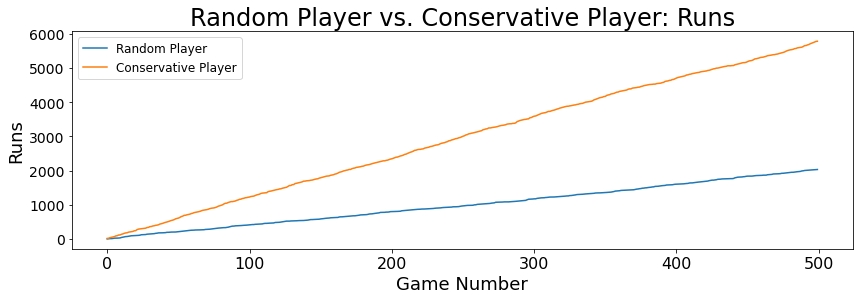

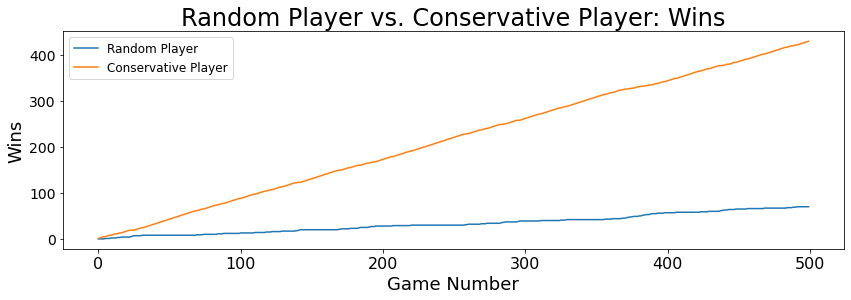

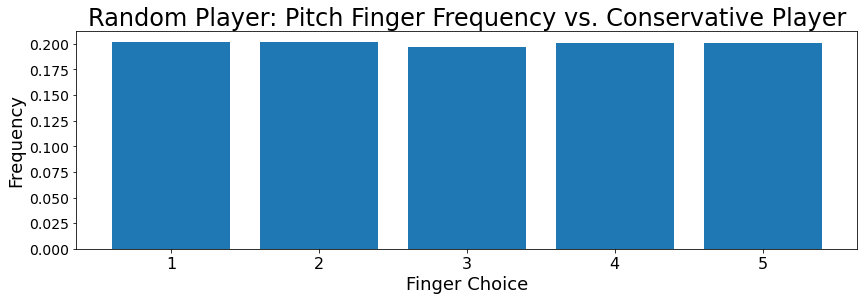

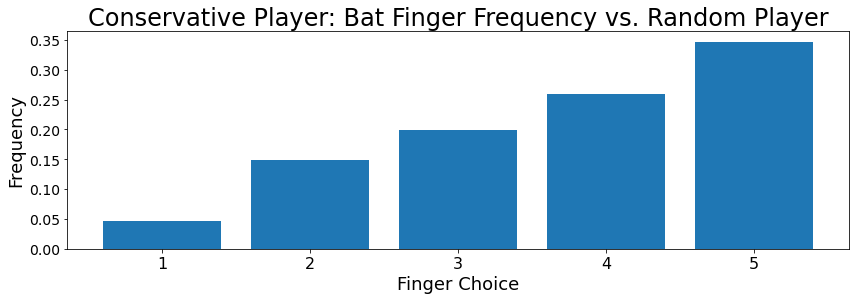

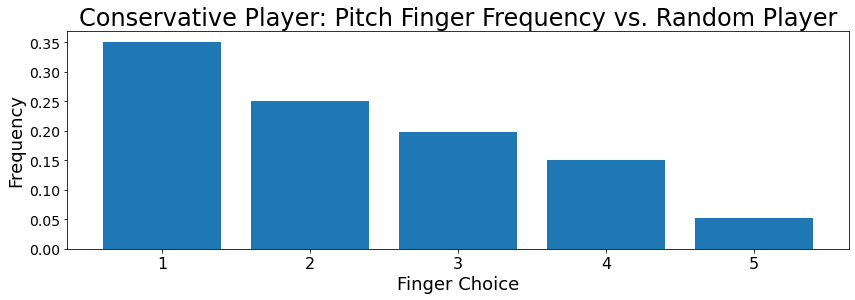

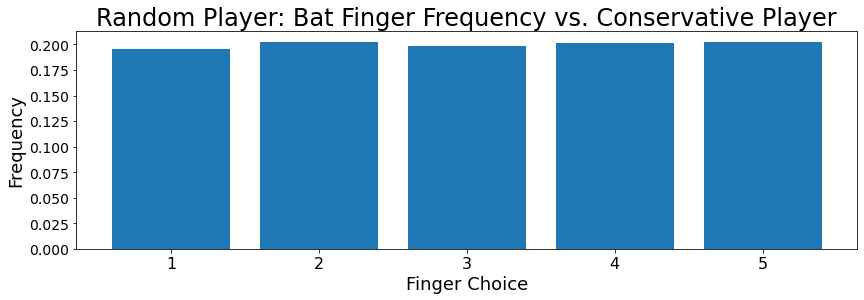

Random Player vs. Calculated Player
Simulating games...


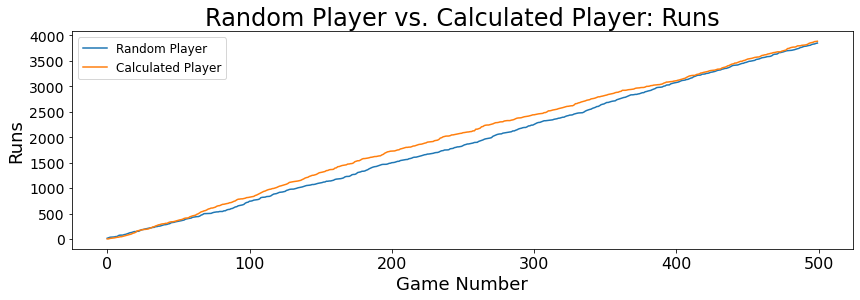

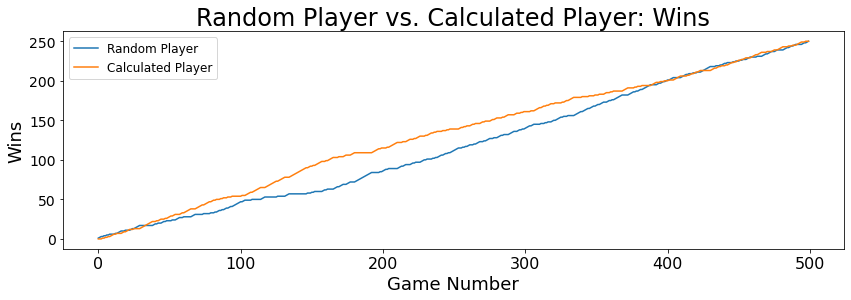

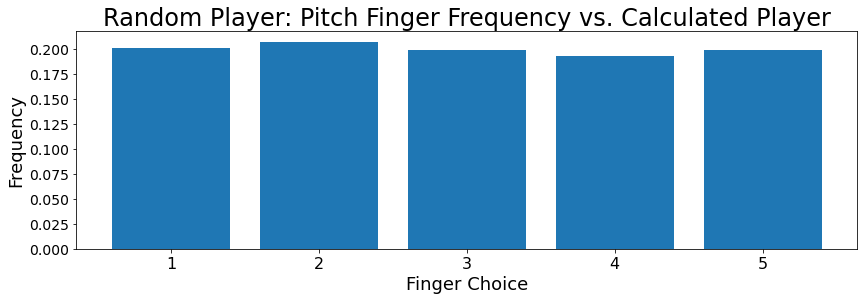

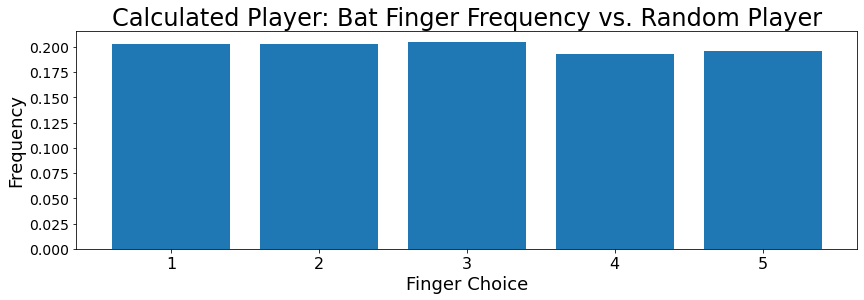

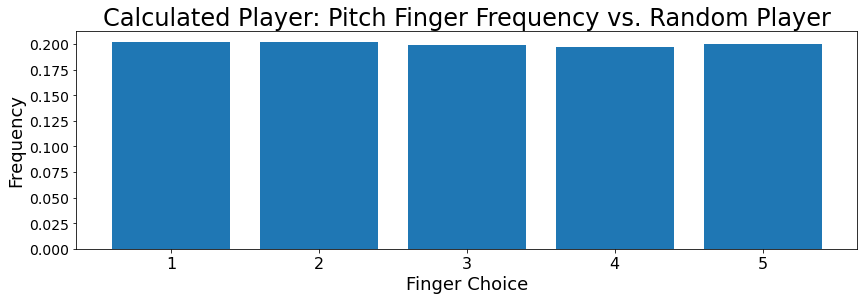

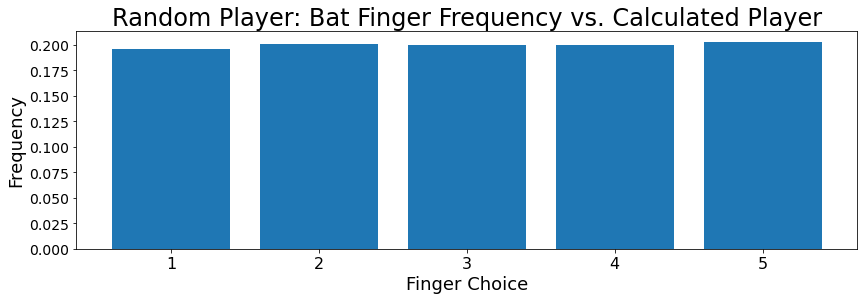

Random Player vs. 1's & 2's Only Player
Simulating games...


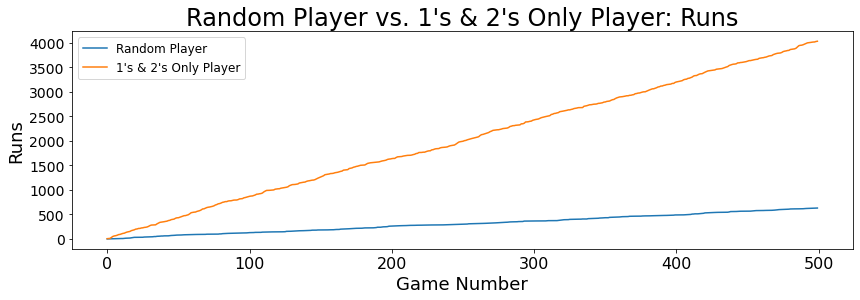

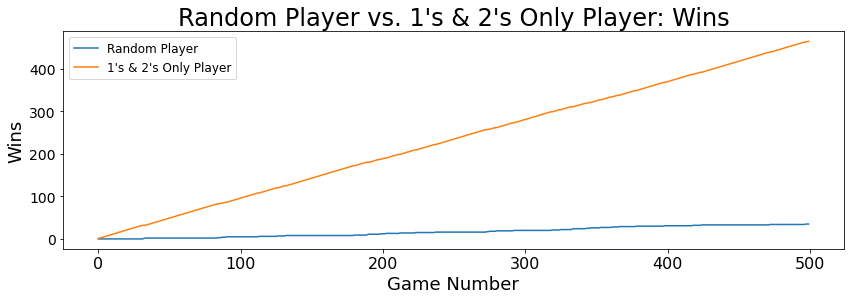

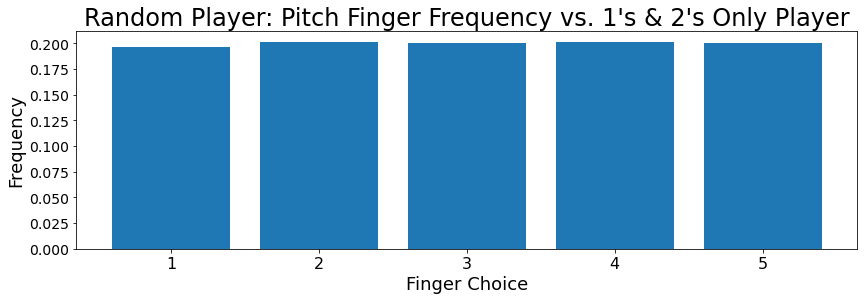

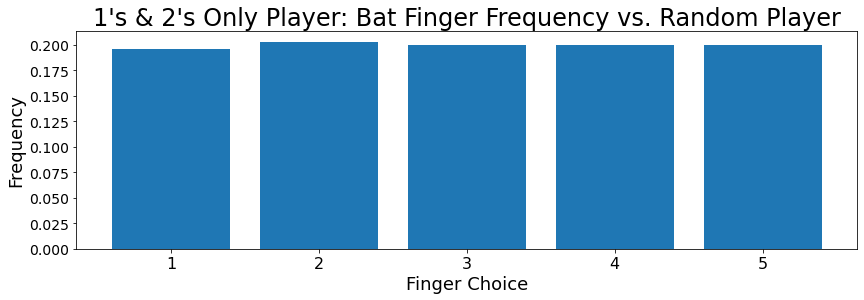

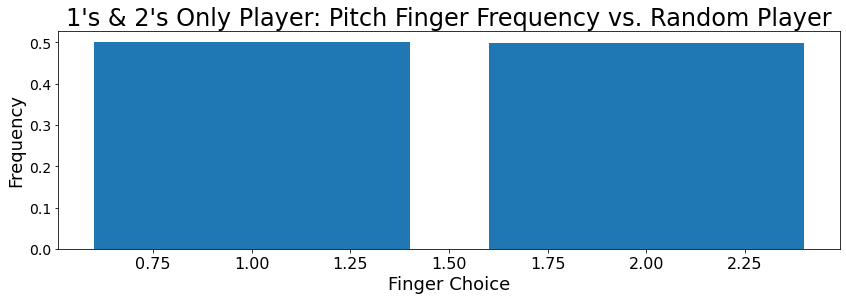

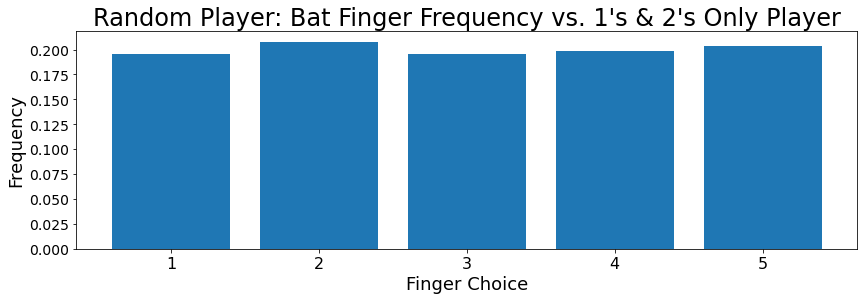

Conservative Player vs. Calculated Player
Simulating games...


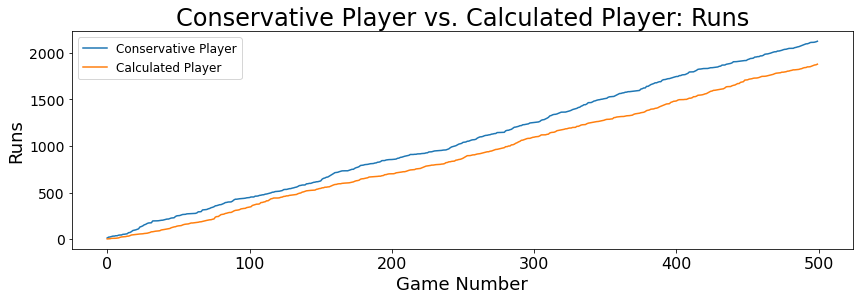

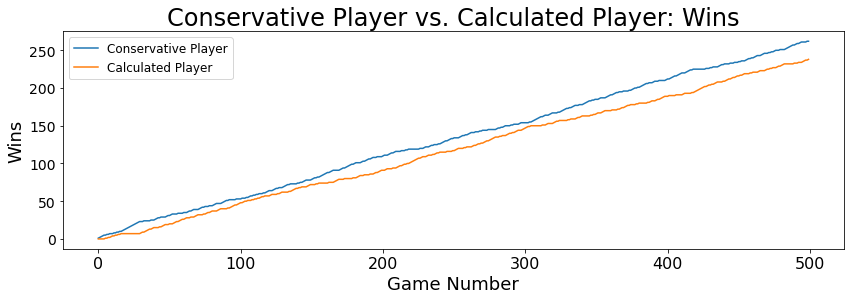

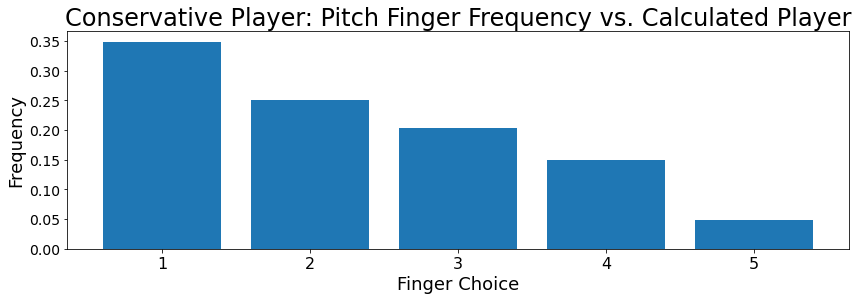

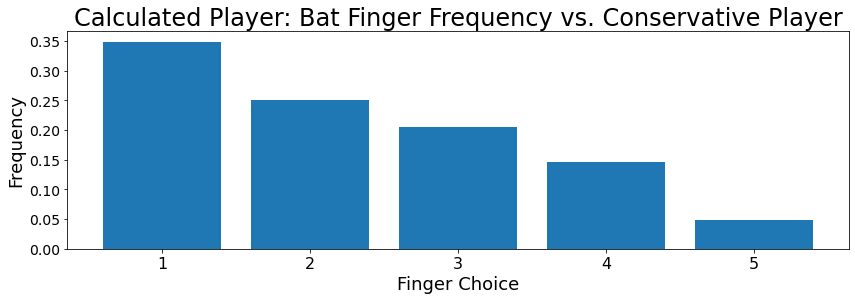

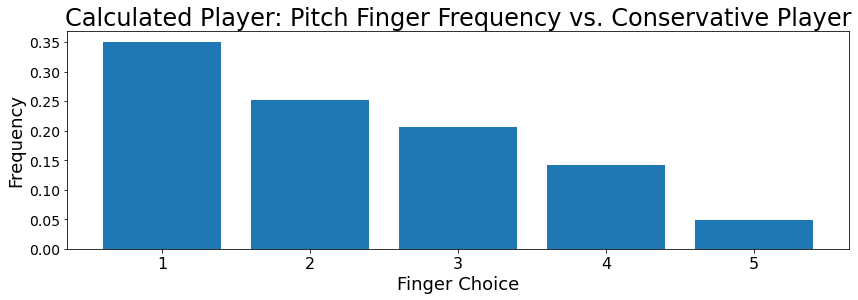

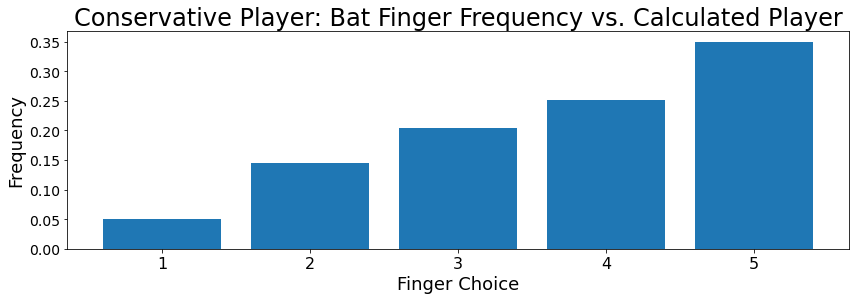

1's & 2's Only Player vs. Conservative Player
Simulating games...


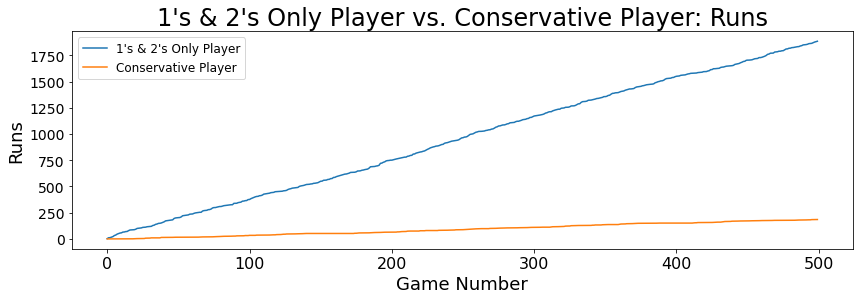

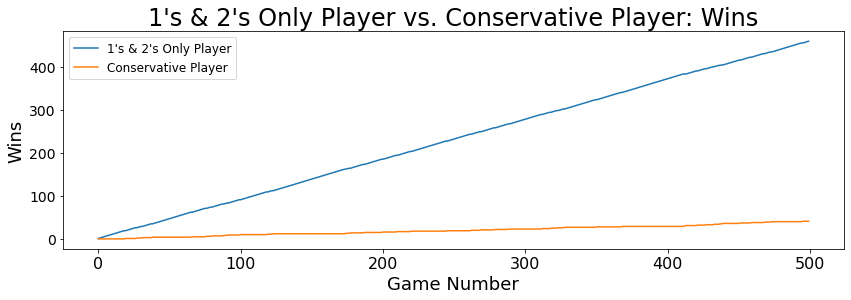

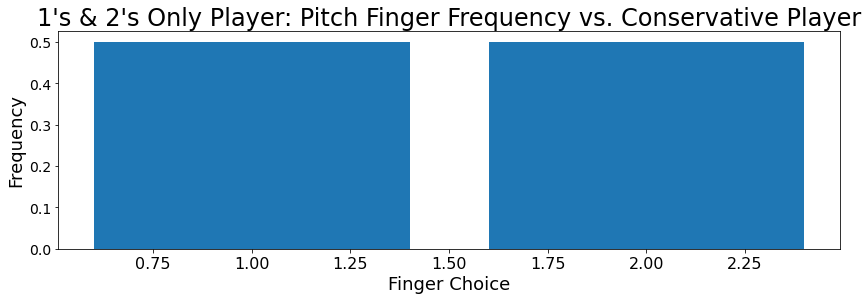

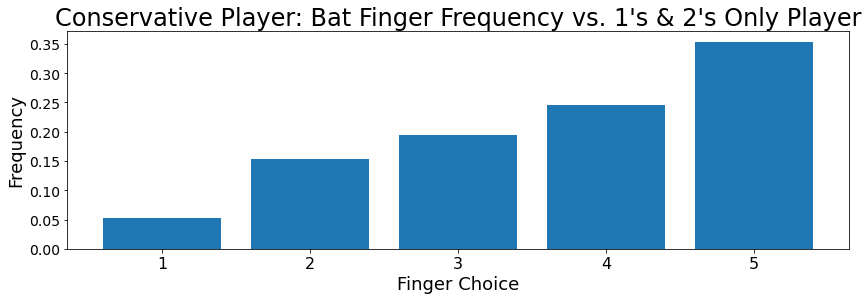

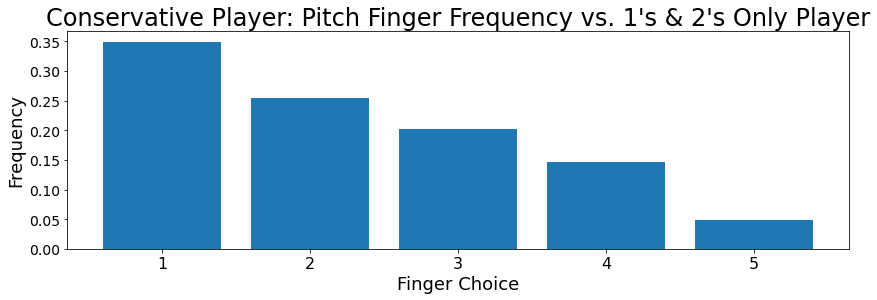

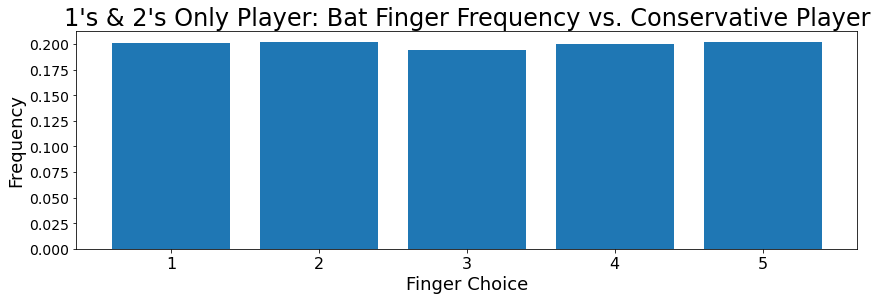

1's & 2's Only Player vs. Calculated Player
Simulating games...


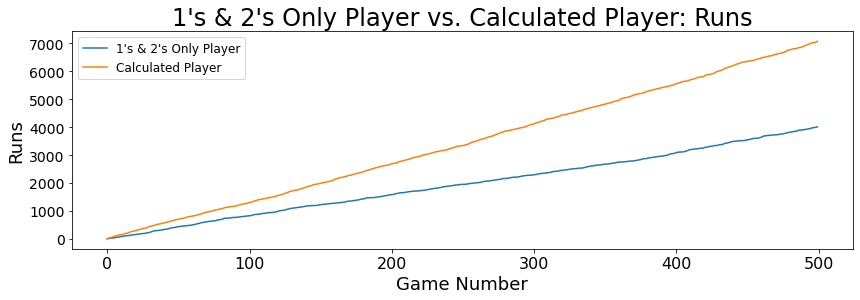

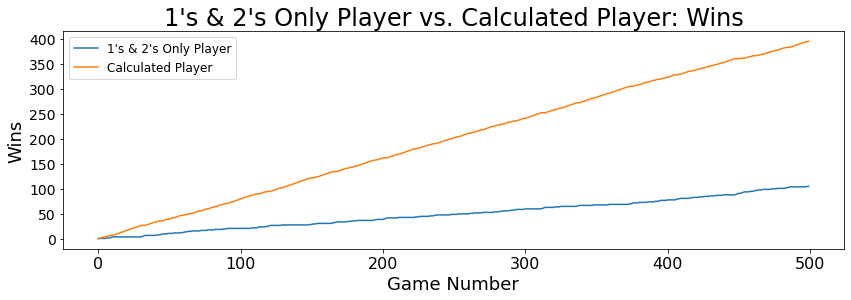

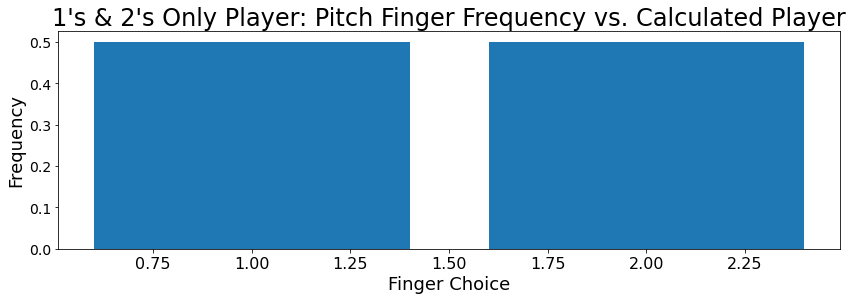

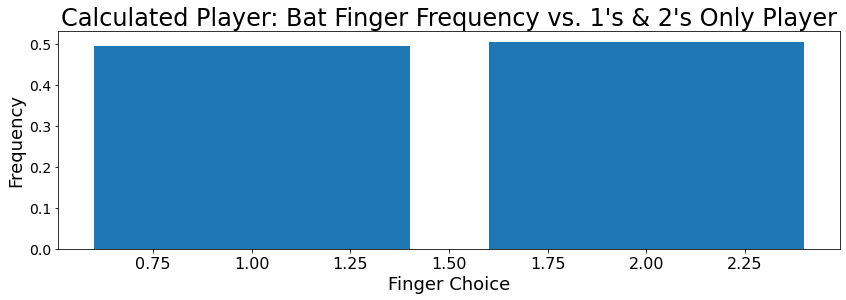

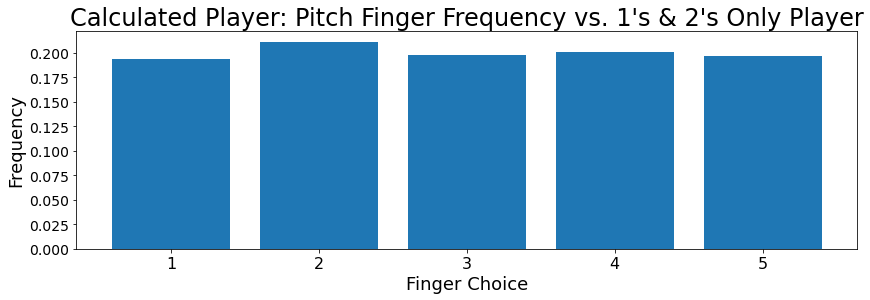

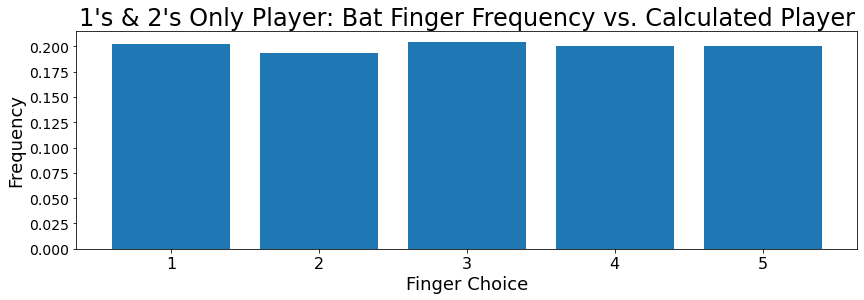

In [2]:
from sim_scaffolding import simulate_games
from players import Player, ConservativePlayer, CalculatedPlayer, OnesAndTwos

strategies = [Player, ConservativePlayer, CalculatedPlayer, OnesAndTwos]

for s1 in strategies:
    for s2 in strategies:
        if s1 != s2 and str(s1) > str(s2): #delete
            p1 = s1()
            p2 = s2()
            simulate_games(p1,p2,n_games=500,echo_first_game=False,plot=True)

Based on this initial experimentation, we can see that playing randomly is an inferior strategy. 

The 1's and 2's player beats the conservative player by a wide margin (since the conservative player misses the mark a lot), but we see how vulnerable it is when the opponent pays attention to its moves, so it seems to be an inferior long-term strategy as well. This isn't too surprising.

The conservative player is the only one able to beat the calculated player, and it isn't by much. However, it is badly beaten by the 1s and 2s player. Even though a perpetually balanced strategy seems reasonable, clearly some reactivity to surroundings is necessary.

With that in mind, the best baseline strategy here is the calculated player - the one that simply forms a probability distribution from the opponent's last 500 moves. The only problem here is it does not take into account the relative value of each move. 

This reality means that a simple classifier (i.e. an effort to simply predict the opponent's next action and act accordingly) would be a poor choice for this game. Clearly, if the player is batting and the player believes that a 1 is very, very slightly more likely than a 5, it might make more sense to play the 5, as the potential reward is greater.

Thus, any algorithm we build should take into account expected reward of a move. 

# Best Simple Algorithm

Perhaps we can extend the "calculated" player to also take into account the value of each move. 

Let's say, for instance, we calculate it as follows...

If a player is batting, the expected value of a finger choice is equal to the frequency with which the opponent uses that move (again over the last 500 moves) multipled by the value of the move.

For argument's sake, we can define a single as being worth .25 runs, a double 0.5, a triple 0.75, a home run 1.0, and a grand slam 4.0. 

We can also take the square root of the values to maintain more balance in the distribution (and perhaps avoid a bias towards grand slams), and normalize them by dividing them by their sum to create a probability distribution (the type of root we take can be adjusted, but a square root works well enough in practice).

If a player is pitching, we can take a similar approach. The only difference is we can multiply all the values by -1 to calculate expected *loss*, then subtract the lowest (i.e. most negative) value to convert it back to expected value (i.e. expected gain from the highest expected loss). 

We could also avoid predictability by adding a mathematical guardrail that makes sure we never select an action (presumably grand slam) less than, say, 1% of the time, but we'll hold off on that for now unless we need it.

Expected Value Player vs. Random Player
Simulating games...


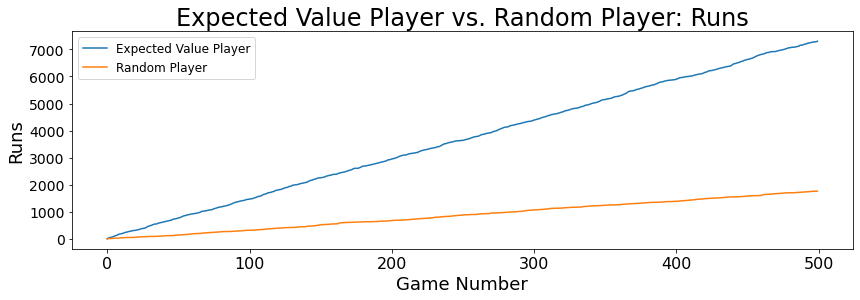

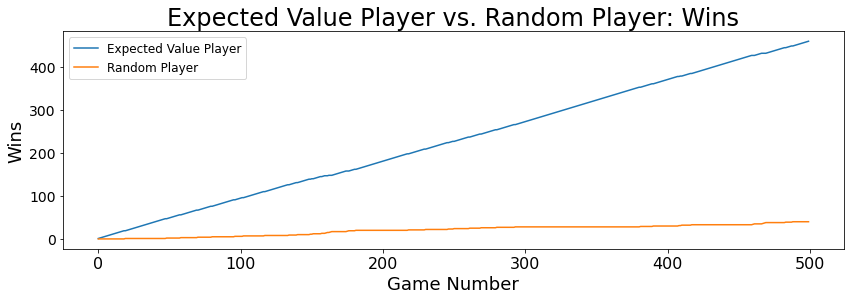

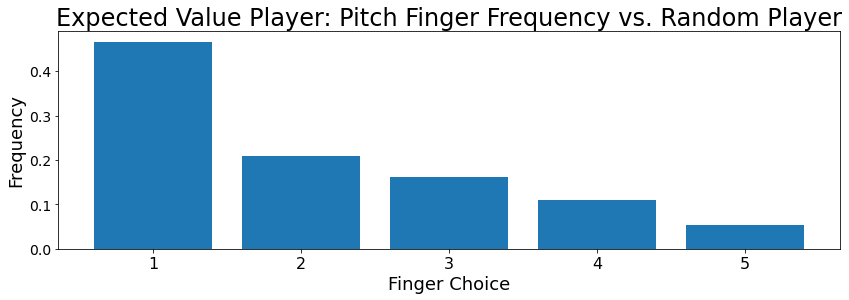

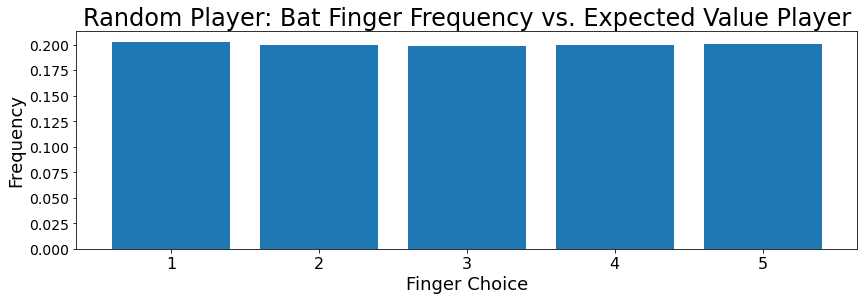

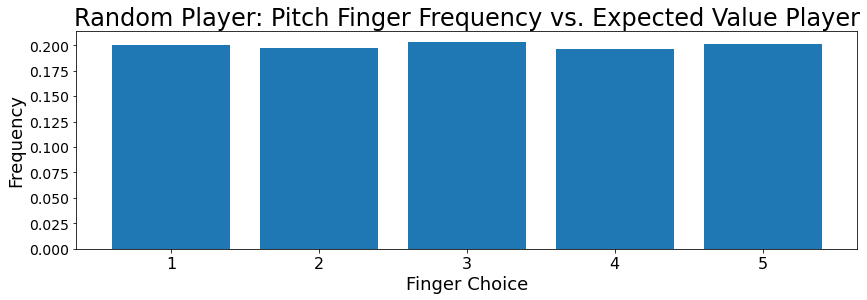

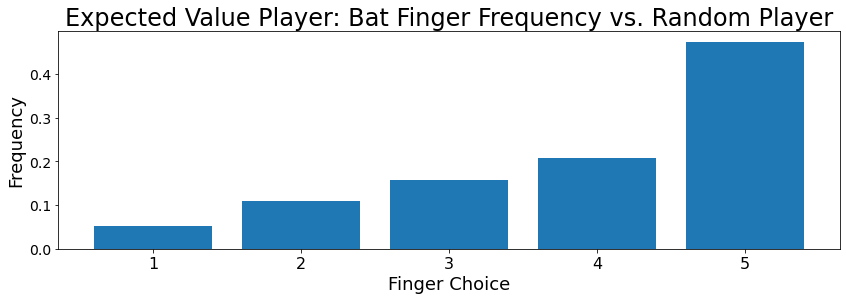

Expected Value Player vs. Conservative Player
Simulating games...


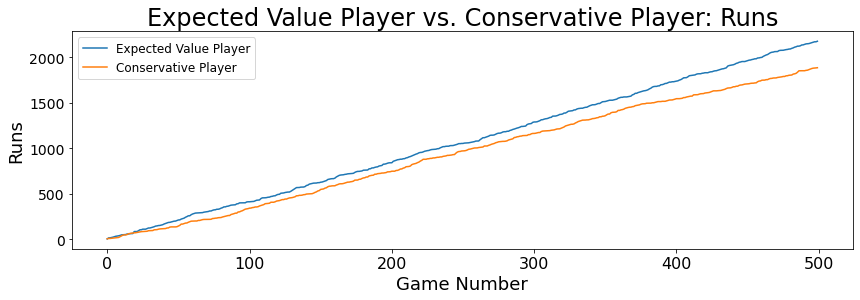

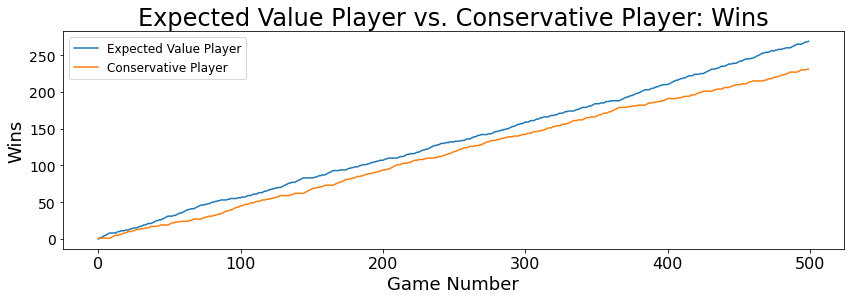

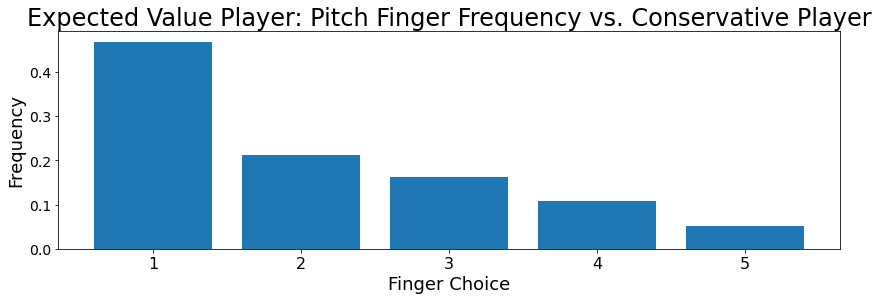

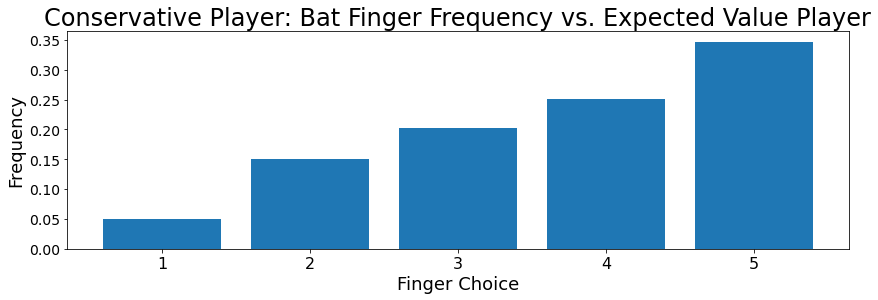

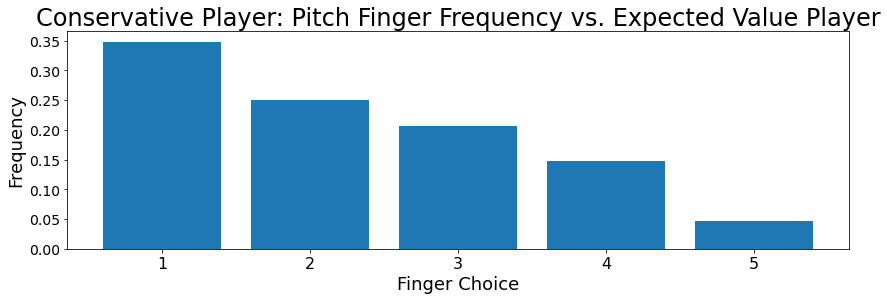

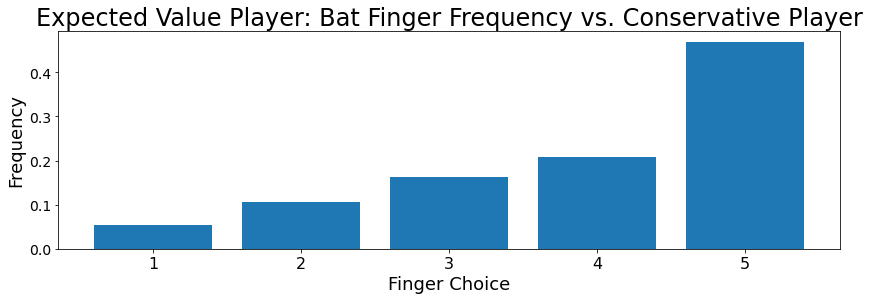

Expected Value Player vs. Calculated Player
Simulating games...


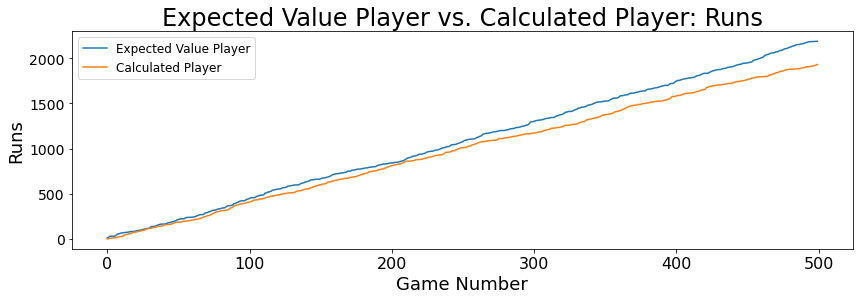

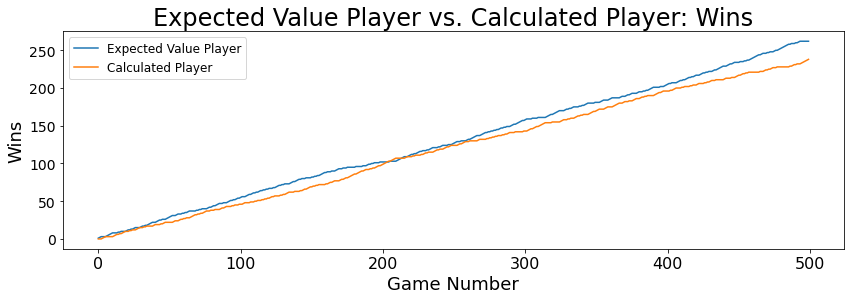

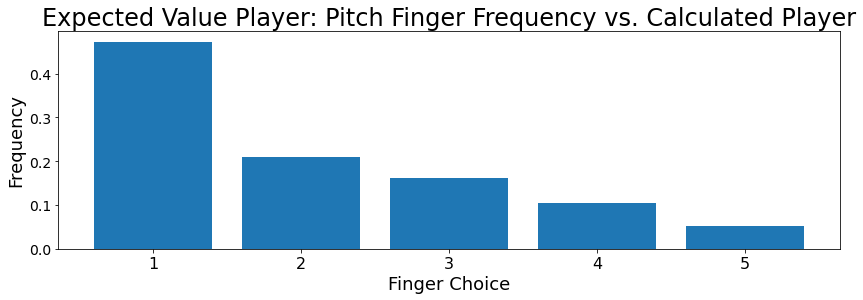

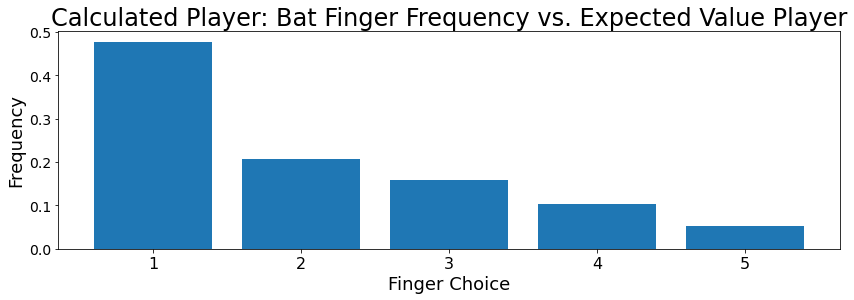

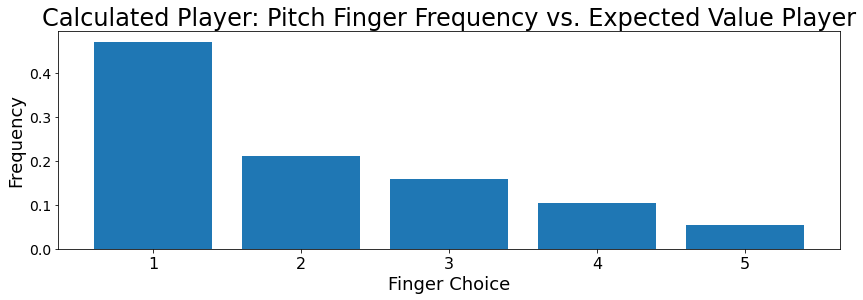

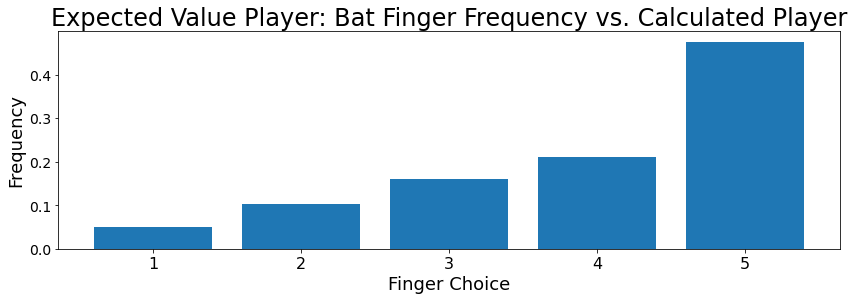

Expected Value Player vs. 1's & 2's Only Player
Simulating games...


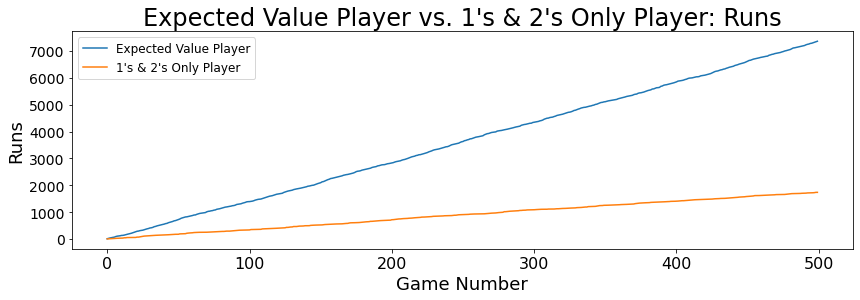

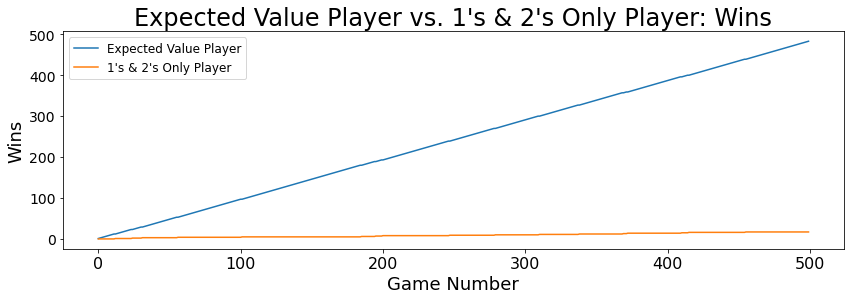

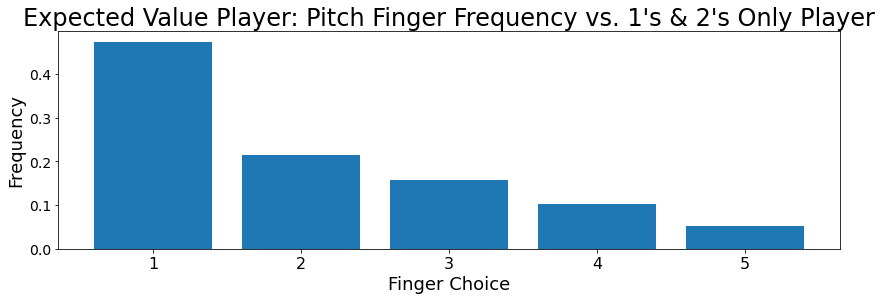

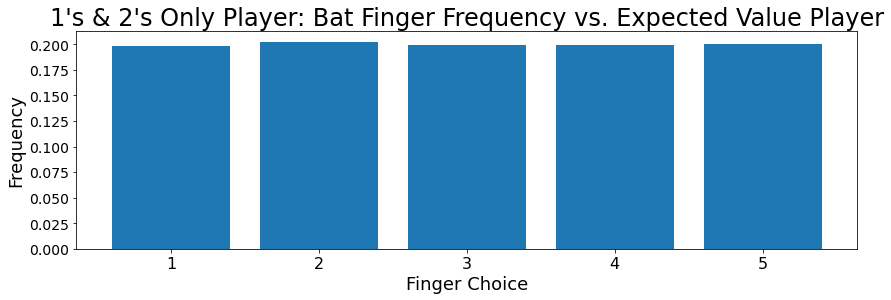

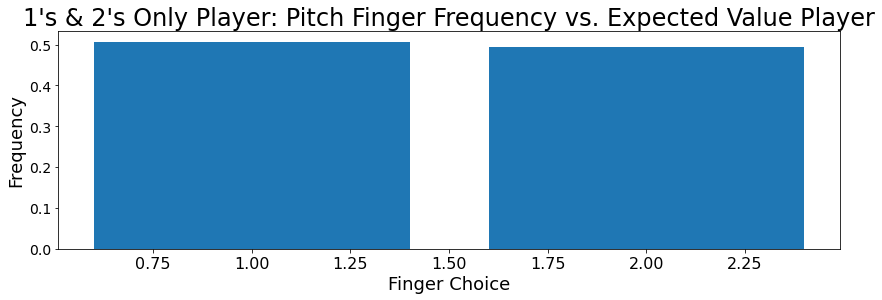

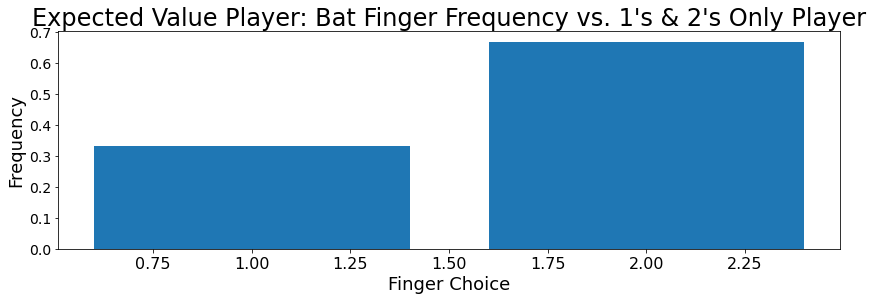

In [3]:
from players import ExpectedValuePlayer

for s in strategies:
    p1 = ExpectedValuePlayer()
    p2 = s()
    simulate_games(p1,p2,n_games=500,echo_first_game=False,plot=True)

Here, we see how strong an expected value strategy (with some balancing to maintain unpredictability) can be. The way the distribution is "flattened" (here a square root is used, but a different root can be used) has a major effect on performance relative to the different baselines. 

A flatter distribution is less susceptible to guessing. A more uneven distribution leads to higher expected rewards. Balancing these two factors is critical.

This is good - the "flattening" gives us something that could be tuned in practice, the same way a player might adjust based on how predictable or random their opponent is. Here, it allowed it to beat every other strategy from the get-go.

For this reason, it's a good baseline to consider against other machine learning strategies, although the calculated and conservative strategies aren't far behind.

# What's Next?

These baselines offer simple, effective strategies - but they probably can't outsmart a human that can get a read on them, so we need a more nuanced strategy that uses machine learning.

**Supervised Learning** is one option. We can predict how effective each number will be in a given spot, and plan accordingly. This is similar to the expected value strategy, but more nuanced.

As mentioned, a classifier (which tries to predict the opponent's move) isn't ideal, because it eschews the notion of move value. A regressor - an algorithm that more methodically predicts the expected value of a move (i.e. the expected number of runs) based on the context its made in - might be better. 

**Reinforcement Learning** is one option. The concept is similar, but functions differently. Here, the player acts as an artifically intelligent agent, considers the state they are in, and uses its experience to determine the most optimal action in that situation. 

Reinforcement Learning isn't wildly better of a fit than Supervised Learning, but it does offer more control over *how* a reward is predicted (which we've seen is useful from our expected value experiment). 

With Reinforcement Learning, we can control things like how random our actions are and how much we react to changes in our opponent's actions, and how these things change over time.

Finally, **Optimization** could make sense as well. Here, we use an algorithm that tunes the probability of each action directly to maximize the chances of success. 

One final note - it could theoretically also make sense to tune batting and hitting separately. Here, similar strategies are used for each (for simplicity), but it's worth noting that totally different strategies may be optimal depending on whether you are pitching or batting.

All this will be worth trying when this project picks up...